# DSP 2

In [15]:
import IPython
wav_file = 'helloworld1.wav'

IPython.display.Audio(wav_file)

In [16]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

sampling_frequency = 16000
y, s = librosa.load('helloworld1.wav', sr=sampling_frequency)
y = (y * 32767).astype(np.int16)

duration = len(y) / sampling_frequency
time_axis = np.arange(len(y)) / sampling_frequency
print(f"Duration: {duration} [s]")

Duration: 1.792 [s]


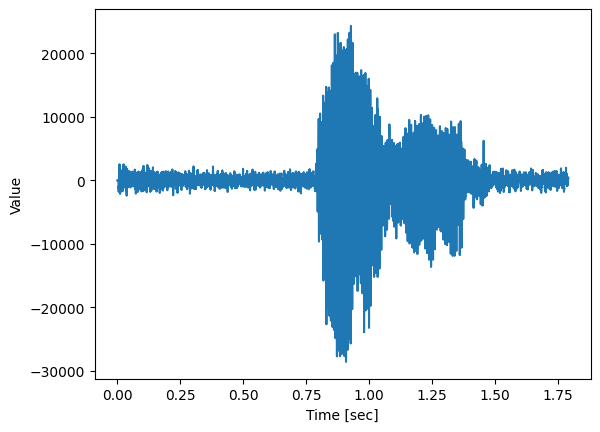

In [17]:
plt.plot(time_axis, y)
plt.xlabel("Time [sec]")
plt.ylabel("Value")
plt.show()

# Window function

In [18]:
from scipy import signal
from scipy.fft import fft, fftshift
import matplotlib.pyplot as plt

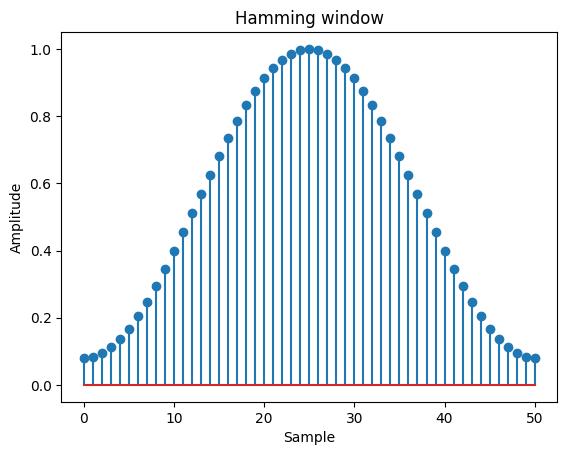

In [19]:
window = signal.windows.hamming(51)
plt.stem(window)
plt.title("Hamming window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.show()

# Spectrogram

In [23]:
num_samples = len(y)
frame_duration = 25 # [ms]
frame_shift_duration = 10 # [ms]

frame_size = int(sampling_frequency * frame_duration / 1000)
frame_shift = int(sampling_frequency * frame_shift_duration / 1000)

fft_size = 512
num_frames = (num_samples)

num_frames = (num_samples - frame_size) // frame_shift + 1
print(f"Number of frames: {num_frames}")

Number of frames: 177


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
spectrogram = np.zeros((num_frames, int(fft_size / 2) + 1))

for frame_idx in range(num_frames):
    start_index = frame_idx * frame_shift
    frame = y[start_index:start_index + frame_size].copy()
    frame = frame * signal.windows.hamming(frame_size)
    spectrum = fft(frame, n=fft_size)
    absolute = np.abs(spectrum)
    absolute = absolute[:int(fft_size/2) + 1]
    log_absolute = np.log(absolute + 1e-7)
    spectrogram[frame_idx, :] = log_absolute

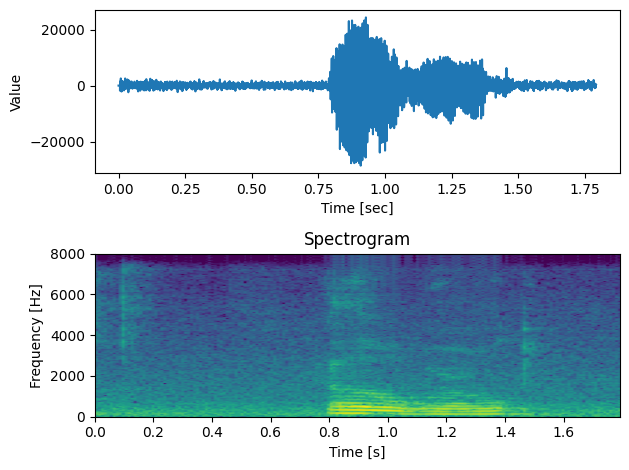

In [27]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(time_axis, y)
plt.xlabel("Time [sec]")
plt.ylabel("Value")

plt.subplot(2, 1, 2)
spectrogram -= np.max(spectrogram)
vmax = np.abs(np.min(spectrogram)) * 0.0
vmin = -np.abs(np.min(spectrogram)) * 0.7

plt.imshow(spectrogram.T[-1::-1,:],
           extent=[0, num_samples / sampling_frequency, 0, sampling_frequency / 2],
           vmax=vmax, vmin=vmin, aspect='auto')
plt.title("Spectrogram")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.tight_layout()
plt.show()

## Filter Bank

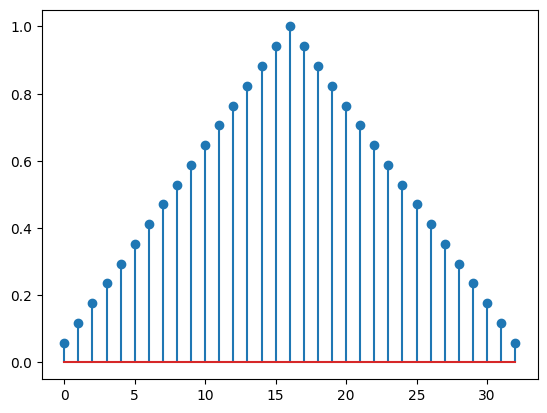

In [30]:
tri = signal.triang(33)
# tri = tri / np.sum(tri)
plt.stem(tri)
plt.show()

In [31]:
feature = np.zeros(log_absolute.shape[0])
np.shape(feature)

(257,)

In [32]:
# Create filter banks
dim_spectrum = 257
num_banks = 7
step_size = 32
bank_size = 64

filter_banks = []
for k in range(num_banks):
    bank = np.zeros(dim_spectrum)
    tri = signal.triang(bank_size)

    f_low = k * step_size
    f_high = f_low + bank_size

    bank[f_low:f_high] = tri

    filter_banks.append(bank)

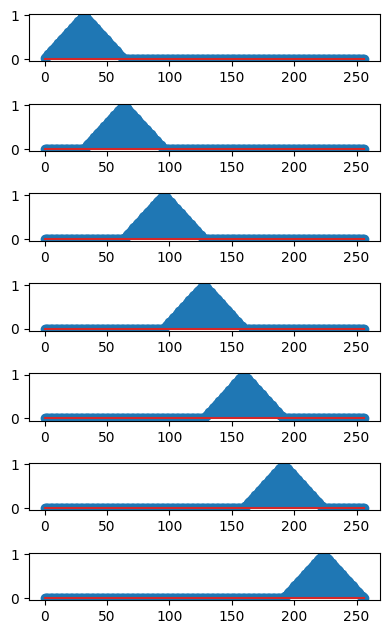

In [42]:
plt.figure(figsize=(4, 8))
for k, bank in enumerate(filter_banks, 1):
    plt.subplot(9, 1, k)
    plt.stem(bank)
plt.tight_layout()
plt.show()

In [34]:
features = []
for bank in filter_banks:
    feature = log_absolute * bank
    features.append(feature)

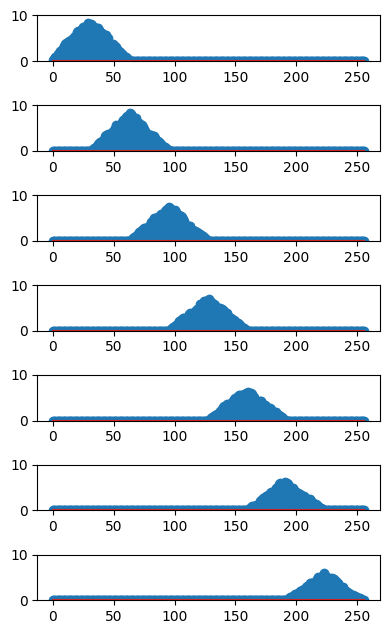

In [41]:
plt.figure(figsize=(4, 8))
for k, bank in enumerate(features, 1):
    plt.subplot(9, 1, k)
    plt.stem(bank)
    plt.ylim([0, 10])
plt.tight_layout()
plt.show()

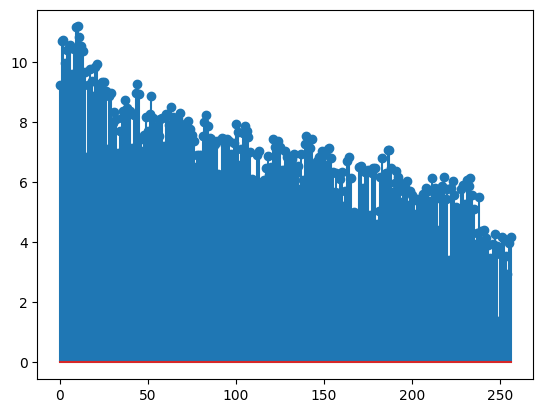

In [43]:
plt.figure()
plt.stem(log_absolute)
plt.show()

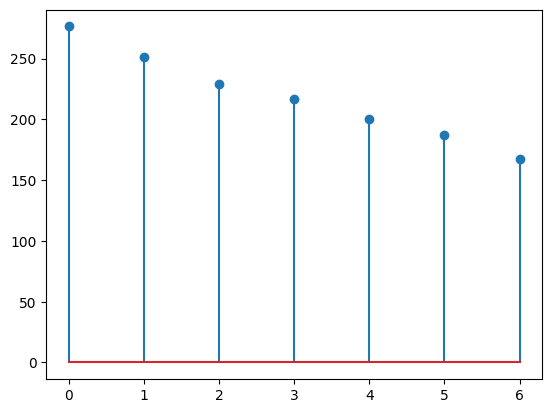

In [44]:
features = np.array(features)
agg_features = np.sum(features, axis=1)

plt.figure()

plt.stem(agg_features)
plt.show()

In [45]:
spectrogram = np.zeros((num_frames, num_banks))
for frame_idx in range(num_frames):
    start_index = frame_idx * frame_shift
    frame = y[start_index:start_index + frame_size].copy()
    frame = frame * signal.windows.hamming(frame_size)
    spectrum = fft(frame, n=fft_size)
    absolute = np.abs(spectrum)
    absolute = absolute[:int(fft_size/2) + 1]
    log_absolute = np.log(absolute + 1e-7)

    features = []
    for bank in filter_banks:
        feature = np.sum(log_absolute * bank)
        features.append(feature)

    features = np.array(features)
    spectrogram[frame_idx,:] = features

Text(0, 0.5, 'Feature index')

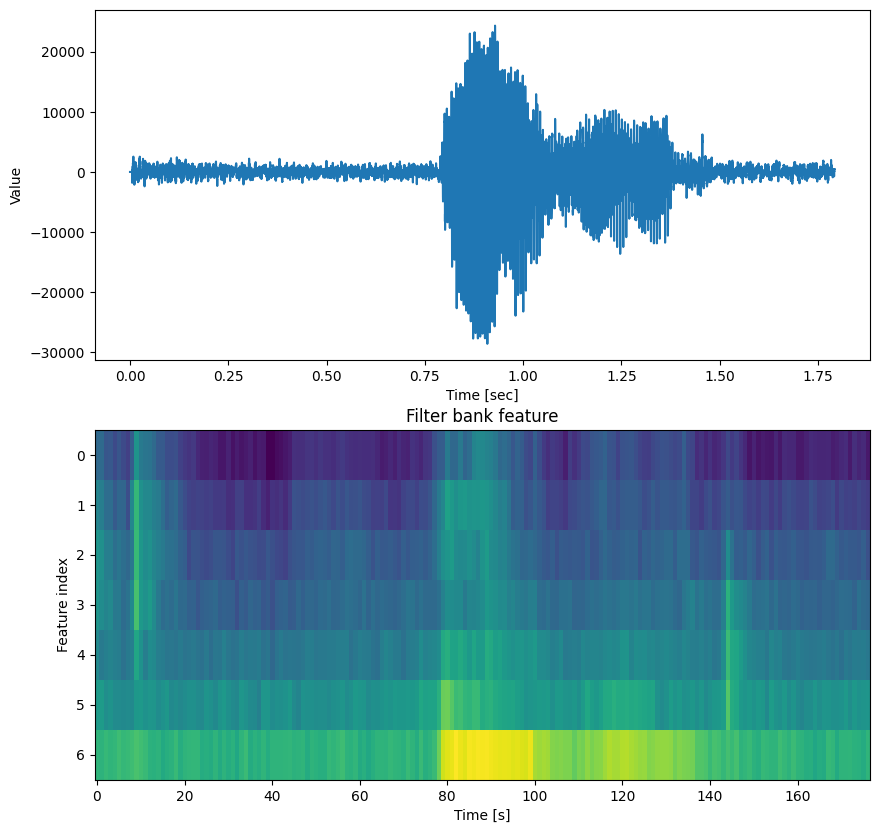

In [46]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(time_axis, y)
plt.xlabel("Time [sec]")
plt.ylabel("Value")

plt.subplot(2, 1, 2)
spectrogram -= np.max(spectrogram)
vmax = np.abs(np.min(spectrogram)) * 0.0
vmin = -np.abs(np.min(spectrogram)) * 0.7

plt.imshow(spectrogram.T[::-1,:],
           aspect='auto')
plt.title("Filter bank feature")
plt.xlabel("Time [s]")
plt.ylabel("Feature index")

# Dynamic Programming Matching

In [47]:
from enum import Enum, IntEnum

class Track(IntEnum):
    TOP = 0
    DIAGONAL = 1
    LEFT = 2

In [48]:
s1 = np.array([1, 4, 9])
s2 = np.array([0, 0, 1, 0, 4, 0, 9])

In [49]:
# Prepare a distance matrix
s1_tiled = np.tile(s1, len(s2)).reshape(len(s2), len(s1)).T
# print(s1_tiled)
s2_tiled = np.tile(s2, len(s1)).reshape(len(s1), len(s2))
# print(s2_tiled)
dist_mat = np.sqrt((s1_tiled - s2_tiled)**2)
# print(dist_mat)

n_rows, n_cols = dist_mat.shape

In [50]:
cost_mat = np.zeros(dist_mat.shape)
track_mat = np.zeros(dist_mat.shape)

In [51]:
# Calculate the costs for the first row and first column
cost_mat[0,0] = dist_mat[0,0]
track_mat[0,0] = Track.TOP

for col in range(1, n_cols):
    cost_mat[0,col] = cost_mat[0,col-1] + dist_mat[0,col]
    track_mat[0,col] = Track.LEFT

for row in range(1, n_rows):
    cost_mat[row, 0] = cost_mat[row-1, 0] + dist_mat[row,0]
    track_mat[row,0] = Track.TOP

In [52]:
# Calculate the cost for the remaining cells
for row in range(1, n_rows):
    for col in range(1, n_cols):
        cost_top = cost_mat[row-1,col] + dist_mat[row,col]
        cost_diagonal = cost_mat[row-1,col-1] + 2*dist_mat[row,col]
        cost_left = cost_mat[row,col-1] + dist_mat[row,col]

        costs = [cost_top, cost_diagonal, cost_left]
        cost_mat[row,col] = np.min(costs)

        if np.argmin(costs) == Track.TOP:
            track_mat[row,col] = Track.TOP
        elif np.argmin(costs) == Track.LEFT:
            track_mat[row,col] = Track.LEFT
        else:
            track_mat[row,col] = Track.DIAGONAL


In [53]:
# Calculate the shortest path
col = n_cols - 1
row = n_rows - 1

alignment = []
alignment.append((row, col))

while col > 0 or row > 0:
    if track_mat[row, col] == Track.TOP:
        row -= 1
    elif track_mat[row, col] == Track.LEFT:
        col -= 1
    else:
        row -= 1
        col -= 1
    alignment.append((row, col))

In [54]:
alignment = np.array(alignment)[::-1]

In [55]:
alignment

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [1, 4],
       [1, 5],
       [2, 6]])

In [56]:
dtw_dist = cost_mat[-1,-1] / np.sum(cost_mat.shape)
print(f"DTW distance: {dtw_dist}")

DTW distance: 0.7


## Aligning two audio signals

In [57]:
# Create filter banks
dim_spectrum = 257
num_banks = 7
step_size = 32
bank_size = 64

filter_banks = []
for k in range(num_banks):
    bank = np.zeros(dim_spectrum)
    tri = signal.triang(bank_size)

    f_low = k * step_size
    f_high = f_low + bank_size

    bank[f_low:f_high] = tri

    filter_banks.append(bank)

### Signal 1

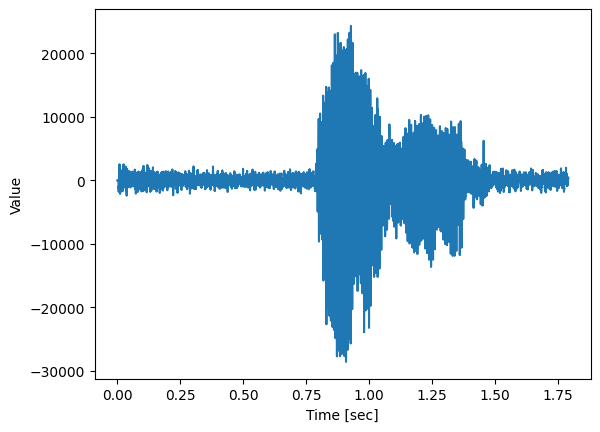

In [58]:
sampling_frequency = 16000
filename_1 = 'helloworld1.wav'
y1, s1 = librosa.load(filename_1, sr=sampling_frequency)
y1 = (y1 * 32767).astype(np.int16)

duration1 = len(y1) / sampling_frequency
time_axis1 = np.arange(len(y1)) / sampling_frequency
plt.plot(time_axis1, y1)
plt.xlabel("Time [sec]")
plt.ylabel("Value")
plt.show()

In [74]:
import IPython
IPython.display.Audio(filename_1)

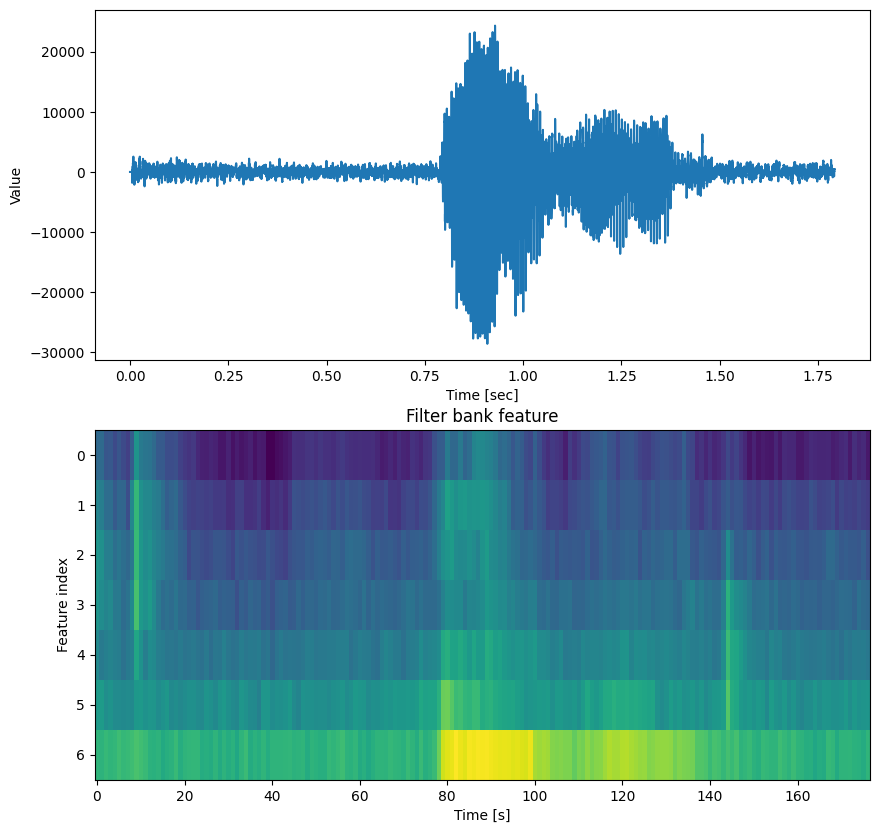

In [73]:
frame_duration = 25 # [ms]
frame_shift_duration = 10 # [ms]

frame_size = int(sampling_frequency * frame_duration / 1000)
frame_shift = int(sampling_frequency * frame_shift_duration / 1000)

fft_size = 512

num_samples = len(y1)
num_frames = (num_samples - frame_size) // frame_shift + 1

dim_spectrum = 257
num_banks = 7
step_size = 32
bank_size = 64

spectrogram1 = np.zeros((num_frames, num_banks))
for frame_idx in range(num_frames):
    start_index = frame_idx * frame_shift
    frame = y1[start_index:start_index + frame_size].copy()
    frame = frame * signal.windows.hamming(frame_size)
    spectrum = fft(frame, n=fft_size)
    absolute = np.abs(spectrum)
    absolute = absolute[:int(fft_size / 2) + 1]
    log_absolute = np.log(absolute + 1e-7)

    features = []
    for bank in filter_banks:
        feature = np.sum(log_absolute * bank)
        features.append(feature)
    features = np.array(features)
    spectrogram1[frame_idx, :] = features

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(time_axis1, y1)
plt.xlabel("Time [sec]")
plt.ylabel("Value")

plt.subplot(2, 1, 2)
spectrogram1 -= np.max(spectrogram1)

plt.imshow(spectrogram1.T[::-1, :],
           aspect='auto')
plt.title("Filter bank feature")
plt.xlabel("Time [s]")
plt.ylabel("Feature index")
plt.show()

### Signal 2

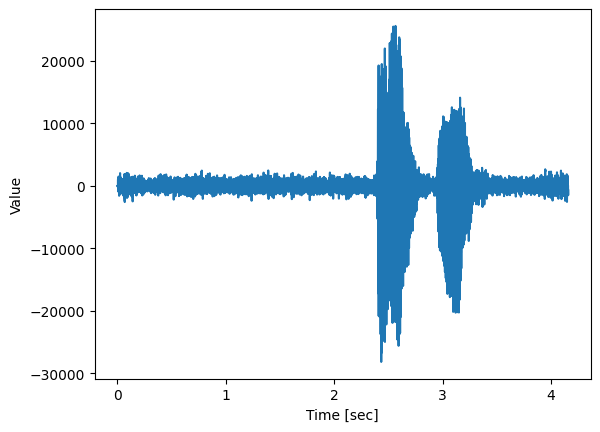

In [75]:
sampling_frequency = 16000
filename_2 = 'helloworld2.wav'
y2, s2 = librosa.load(filename_2, sr=sampling_frequency)
y2 = (y2 * 32767).astype(np.int16)

duration2 = len(y2) / sampling_frequency
time_axis2 = np.arange(len(y2)) / sampling_frequency
plt.plot(time_axis2, y2)
plt.xlabel("Time [sec]")
plt.ylabel("Value")
plt.show()

In [76]:
import IPython
IPython.display.Audio(filename_2)

Text(0, 0.5, 'Feature index')

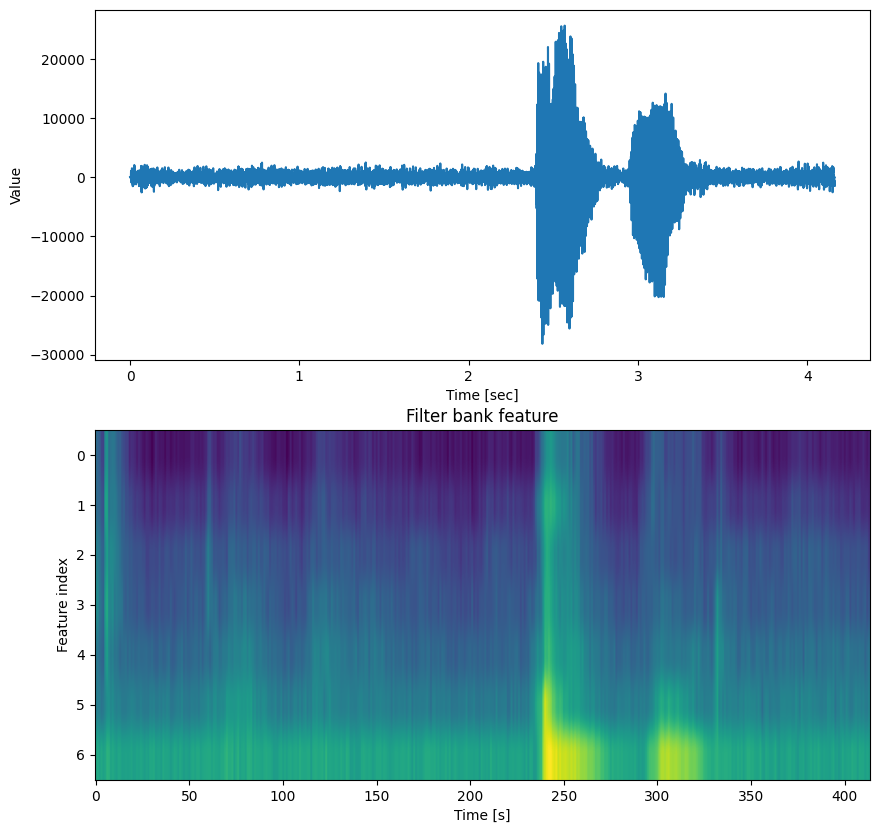

In [77]:
num_samples = len(y2)
num_frames = (num_samples - frame_size) // frame_shift + 1

dim_spectrum = 257
num_banks = 7
step_size = 32

spectrogram2 = np.zeros((num_frames, num_banks))
for frame_idx in range(num_frames):
    start_index = frame_idx * frame_shift
    frame = y2[start_index:start_index + frame_size].copy()
    frame = frame * signal.windows.hamming(frame_size)
    spectrum = fft(frame, n=fft_size)
    absolute = np.abs(spectrum)
    absolute = absolute[:int(fft_size / 2) + 1]
    log_absolute = np.log(absolute + 1e-7)

    features = []
    for bank in filter_banks:
        feature = np.sum(log_absolute * bank)
        features.append(feature)
    features = np.array(features)
    spectrogram2[frame_idx, :] = features

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(time_axis2, y2)
plt.xlabel("Time [sec]")
plt.ylabel("Value")

plt.subplot(2, 1, 2)
spectrogram2 -= np.max(spectrogram2)

plt.imshow(spectrogram2.T[::-1, :],
           aspect='auto')
plt.title("Filter bank feature")
plt.xlabel("Time [s]")
plt.ylabel("Feature index")

In [78]:
print(f"Spectrogram 1: {spectrogram1.shape}")
print(f"Spectrogram 2: {spectrogram2.shape}")

Spectrogram 1: (177, 7)
Spectrogram 2: (414, 7)


In [79]:
# Prepare a distance matrix

s1_len = spectrogram1.shape[0]
s2_len = spectrogram2.shape[0]

s1_tiled = np.tile(spectrogram1, s2_len).reshape((s1_len, s2_len, num_banks)).transpose(1, 0, 2)
s2_tiled = np.tile(spectrogram2, s1_len).reshape((s2_len, s1_len, num_banks))

dist_mat12 = np.linalg.norm(s1_tiled - s2_tiled, axis=2).T

In [80]:
n_rows, n_cols = dist_mat12.shape
cost_mat12 = np.zeros(dist_mat12.shape)
track_mat = np.zeros(dist_mat12.shape)
# Calculate the costs for the first row and first column
cost_mat12[0, 0] = dist_mat12[0, 0]
track_mat[0, 0] = Track.TOP

for col in range(1, n_cols):
    cost_mat12[0, col] = cost_mat12[0, col - 1] + dist_mat12[0, col]
    track_mat[0, col] = Track.LEFT

for row in range(1, n_rows):
    cost_mat12[row, 0] = cost_mat12[row - 1, 0] + dist_mat12[row, 0]
    track_mat[row, 0] = Track.TOP
# Calculate the cost for the remaining cells
for row in range(1, n_rows):
    for col in range(1, n_cols):
        cost_top = cost_mat12[row - 1, col] + dist_mat12[row, col]
        cost_diagonal = cost_mat12[row - 1, col - 1] + 2 * dist_mat12[row, col]
        cost_left = cost_mat12[row, col - 1] + dist_mat12[row, col]

        costs = [cost_top, cost_diagonal, cost_left]
        cost_mat12[row, col] = np.min(costs)

        if np.argmin(costs) == Track.TOP:
            track_mat[row, col] = Track.TOP
        elif np.argmin(costs) == Track.LEFT:
            track_mat[row, col] = Track.LEFT
        else:
            track_mat[row, col] = Track.DIAGONAL

# Calculate the shortest path
col = n_cols - 1
row = n_rows - 1

alignment = []
alignment.append((row, col))

while col > 0 or row > 0:
    if track_mat[row, col] == Track.TOP:
        row -= 1
    elif track_mat[row, col] == Track.LEFT:
        col -= 1
    else:
        row -= 1
        col -= 1
    alignment.append((row, col))
alignment = np.array(alignment)[::-1]

In [81]:
dtw_dist_12 = cost_mat12[-1,-1] / np.sum(cost_mat.shape)
print(f"Cost: {cost_mat12[-1,-1]}, DTW distance: {dtw_dist_12}")

Cost: 25831.20626705722, DTW distance: 2583.120626705722


In [82]:
new_spectrogram1 = np.zeros((alignment.shape[0], num_banks))
new_spectrogram2 = np.zeros((alignment.shape[0], num_banks))

for idx, alg in enumerate(alignment):
    new_spectrogram1[idx,:] = spectrogram1[alg[0],:]
    new_spectrogram2[idx,:] = spectrogram2[alg[1],:]

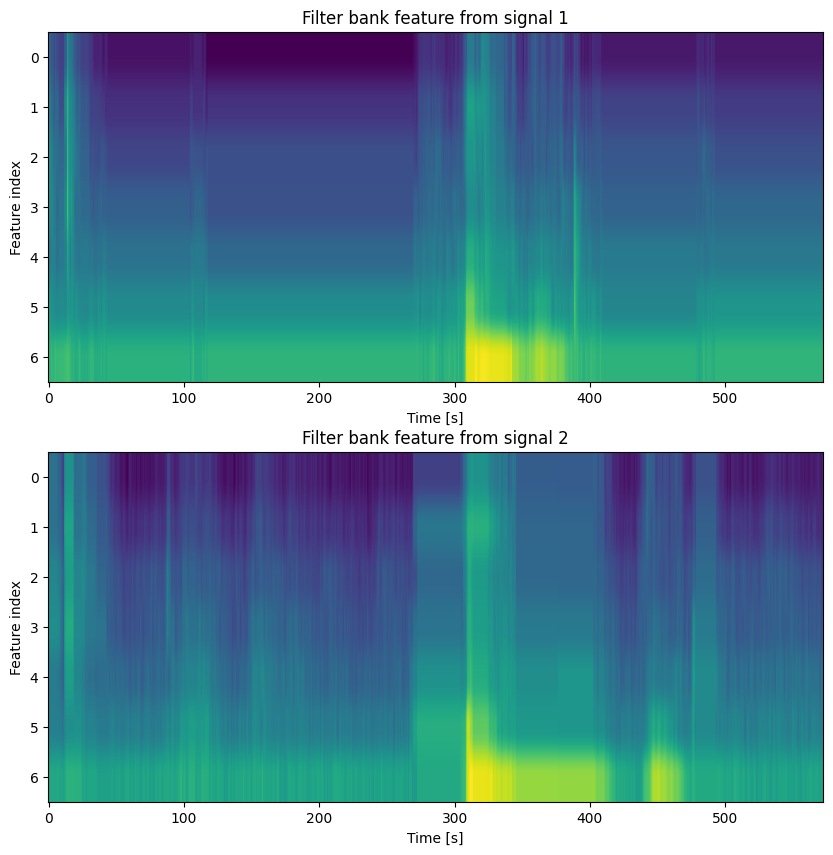

In [83]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
new_spectrogram1 -= np.max(new_spectrogram1)

plt.imshow(new_spectrogram1.T[::-1, :],
           aspect='auto')
plt.title("Filter bank feature from signal 1")
plt.xlabel("Time [s]")
plt.ylabel("Feature index")

plt.subplot(2, 1, 2)
new_spectrogram2 -= np.max(new_spectrogram2)

plt.imshow(new_spectrogram2.T[::-1, :],
           aspect='auto')
plt.title("Filter bank feature from signal 2")
plt.xlabel("Time [s]")
plt.ylabel("Feature index")
plt.show()

In [63]:
alignment.shape

(573, 2)